# Improving Computer Vision Accuracy using Convolutions
In the previous lessons you saw how to do fashion recognition using a Deep Neural Network (DNN) containing three layers -- the input layer (in the shape of the data), the output layer (in the shape of the desired output) and a hidden layer. You experimented with the impact of different sizes of hidden layer, number of training epochs etc on the final accuracy.

In [5]:
!watch -n0.1 nvidia-smi

>

In [2]:
import numpy as np
np.set_printoptions(linewidth=200)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

In [3]:
from keras import backend as K
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  print("Null")
  pass

In [4]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        thres = 0.99
        if(logs.get('accuracy') is not None and logs.get('accuracy') >= thres) : # Experiment with changing this value
            print(f"\nReached {thres*100}% accuracy on epoch = {epoch+1}!")
            self.model.stop_training = True

In [ ]:
def train_fmnist():
    callback =myCallback()

    fmnist = tf.keras.datasets.fashion_mnist

    (x_train, y_train),(x_test, y_test) = fmnist.load_data()

    x_train = x_train / 255.0
    x_test = x_test / 255.0

    model = Sequential([
        Flatten(),
        Dense(512, activation=tf.nn.relu),
        Dense(256, activation=tf.nn.relu),
        Dense(10, activation=tf.nn.softmax)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # model fitting
    history = model.fit(x_train, y_train, epochs=5, callbacks=[callback], verbose=1)
    return history.epoch, history.history['accuracy'][-1]

In [ ]:
train_fmnist()

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4694 - accuracy: 0.8298
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3571 - accuracy: 0.8683
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3189 - accuracy: 0.8817
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2955 - accuracy: 0.8896
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2793 - accuracy: 0.8951


([0, 1, 2, 3, 4], 0.8951166868209839)

Your accuracy is probably about 89% on training and 87% on validation...not bad...But how do you make that even better? One way is to use something called Convolutions. I'm not going to details on Convolutions here, but the ultimate concept is that they narrow down the content of the image to focus on specific, distinct, details.

If you've ever done image processing using a filter (like this: [https://en.wikipedia.org/wiki/Kernel_(image_processing)](https://en.wikipedia.org/wiki/Kernel_(image_processing))) then convolutions will look very familiar.

In short, you take an array (usually 3x3 or 5x5) and pass it over the image. By changing the underlying pixels based on the formula within that matrix, you can do things like edge detection. So, for example, if you look at the above link, you'll see a 3x3 that is defined for edge detection where the middle cell is 8, and all of its neighbors are -1. In this case, for each pixel, you would multiply its value by 8, then subtract the value of each neighbor. Do this for every pixel, and you'll end up with a new image that has the edges enhanced.

This is perfect for computer vision, because often it's features that can get highlighted like this that distinguish one item for another, and the amount of information needed is then much less...because you'll just train on the highlighted features.

That's the concept of Convolutional Neural Networks. Add some layers to do convolution before you have the dense layers, and then the information going to the dense layers is more focussed, and possibly more accurate.

Run the below code -- this is the same neural network as earlier, but this time with Convolutional layers added first. It will take longer, but look at the impact on the accuracy:

In [6]:
callback =myCallback()

fmnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fmnist.load_data()

x_train = x_train.reshape(60000, 28, 28, 1)
x_train = x_train / 255.0
x_test = x_test.reshape(10000, 28, 28, 1)
x_test = x_test / 255.0

model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPool2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(256, activation=tf.nn.relu),
    Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# model fitting
history = model.fit(x_train, y_train, epochs=10, callbacks=[callback], verbose=1)
model.summary()

4431872/4422102 [==============================] - 0s 0us/step
Epoch 1/10
1875/1875 [==============================] - 47s 9ms/step - loss: 0.4420 - accuracy: 0.8379
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2979 - accuracy: 0.8905
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2544 - accuracy: 0.9049
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2225 - accuracy: 0.9166
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1982 - accuracy: 0.9254
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1780 - accuracy: 0.9337
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1568 - accuracy: 0.9406
Epoch 8/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1393 - accuracy: 0.9464
Epoch 9/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1266 - accuracy: 0.9512
Epoch 10/1


It's likely gone up to about 93% on the training data and 91% on the validation data.

That's significant, and a step in the right direction!

Try running it for more epochs -- say about 20, and explore the results! But while the results might seem really good, the validation results may actually go down, due to something called 'overfitting' which will be discussed later.

(In a nutshell, 'overfitting' occurs when the network learns the data from the training set really well, but it's too specialised to only that data, and as a result is less effective at seeing other data. For example, if all your life you only saw red shoes, then when you see a red shoe you would be very good at identifying it, but blue suade shoes might confuse you...and you know you should never mess with my blue suede shoes.)

Then, look at the code again, and see, step by step how the Convolutions were built:

Step 1 is to gather the data. You'll notice that there's a bit of a change here in that the training data needed to be reshaped. That's because the first convolution expects a single tensor containing everything, so instead of 60,000 28x28x1 items in a list, we have a single 4D list that is 60,000x28x28x1, and the same for the test images. If you don't do this, you'll get an error when training as the Convolutions do not recognize the shape.

Next is to define your model. Now instead of the input layer at the top, you're going to add a Convolution. The parameters are:

The number of convolutions you want to generate. Purely arbitrary, but good to start with something in the order of 32
The size of the Convolution, in this case a 3x3 grid
The activation function to use -- in this case we'll use relu, which you might recall is the equivalent of returning x when x>0, else returning 0
In the first layer, the shape of the input data.
You'll follow the Convolution with a MaxPooling layer which is then designed to compress the image, while maintaining the content of the features that were highlighted by the convlution. By specifying (2,2) for the MaxPooling, the effect is to quarter the size of the image. Without going into too much detail here, the idea is that it creates a 2x2 array of pixels, and picks the biggest one, thus turning 4 pixels into 1. It repeats this across the image, and in so doing halves the number of horizontal, and halves the number of vertical pixels, effectively reducing the image by 25%.

You can call model.summary() to see the size and shape of the network, and you'll notice that after every MaxPooling layer, the image size is reduced in this way.

# Visualizing the Convolutions and Pooling
This code will show us the convolutions graphically. The print (test_labels[:100]) shows us the first 100 labels in the test set, and you can see that the ones at index 0, index 23 and index 28 are all the same value (9). They're all shoes. Let's take a look at the result of running the convolution on each, and you'll begin to see common features between them emerge. Now, when the DNN is training on that data, it's working with a lot less, and it's perhaps finding a commonality between shoes based on this convolution/pooling combination.

In [ ]:
print(y_test[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4
 2]


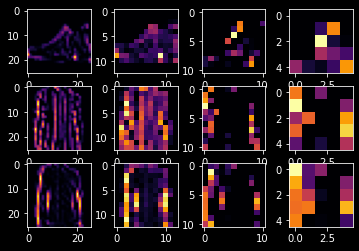

In [ ]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0
SECOND_IMAGE=7
THIRD_IMAGE=26
CONVOLUTION_NUMBER = 1
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
for x in range(0,4):
  f1 = activation_model.predict(x_test[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  f2 = activation_model.predict(x_test[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  f3 = activation_model.predict(x_test[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)
